In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import *
from iminuit import Minuit, describe, Struct
from scipy.interpolate import interp1d
from scipy.special import gammaln
import pandas as pd

sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/Modules/")
# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw

# Siddharth and Laura's Stuff
from NPTFit import create_mask as cm
import constants_noh as constants
import units

3.9684111346791475e-23
1.1160915000000002e+63
0.7


In [2]:
trials = 1000
channel = 'b'
Nb = 2
conc = "SP"
xsec = 1e-22
marr = [100]
ebins = [2,6]

In [3]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('fermi_data/fermidata_exposure.npy'))
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
area_rat = (len(mask[~mask]))/len(mask)

In [4]:
# Defining some constants
r_s = 199 # scale radius, [kpc]
alpha = 0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e12 # [M_s]
mMin_calib = 1e8 # [M_s]
mMax_calib = 1e10 # [M_s]
mMin = 1e-5*M_MW
mMax = .01*M_MW # [M_s]
min_flux = np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask])))

In [5]:
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)

N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos
N_subs = np.random.poisson(N_subs)
print(N_subs)

m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 8000) # mass values to test
def mCDFInv(r):
    return ( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*r)**(-1/.9)

rho_s2 = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, 2000)[0]
def rho_Ein(r): # Einasto density Profile
    return rho_s2 * np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

2239


In [6]:
r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
r_sampler = InverseTransform.InverseTransform(lambda r: r**2 * rho_Ein(r), r_arr, nsamples=N_subs)
m_sampler = InverseTransform.InverseTransform(dNdm_func, m_arr, nsamples=N_subs, cdfinv=mCDFInv)

In [7]:
dNdLogx_df = pd.read_csv('Data/AtProduction_gammas.dat', delim_whitespace=True)
mass_arr = np.array([1.00000000e+01,1.50000000e+01,2.00000000e+01,2.50000000e+01,3.00000000e+01,4.00000000e+01,5.00000000e+01,6.00000000e+01,7.00000000e+01,8.00000000e+01,9.00000000e+01,1.00000000e+02,1.10000000e+02,1.20000000e+02,1.30000000e+02,1.40000000e+02,1.50000000e+02,1.60000000e+02,1.80000000e+02,2.00000000e+02,2.20000000e+02,2.40000000e+02,2.60000000e+02,2.80000000e+02,3.00000000e+02,3.30000000e+02,3.60000000e+02,4.00000000e+02,4.50000000e+02,5.00000000e+02,5.50000000e+02,6.00000000e+02,6.50000000e+02,7.00000000e+02,7.50000000e+02,8.00000000e+02,9.00000000e+02,1.00000000e+03,1.10000000e+03,1.20000000e+03,1.30000000e+03,1.50000000e+03,1.70000000e+03,2.00000000e+03,2.50000000e+03,3.00000000e+03,4.00000000e+03,5.00000000e+03,6.00000000e+03,7.00000000e+03,8.00000000e+03,9.00000000e+03,1.00000000e+04])
PPnoxsec_arr = np.zeros(len(mass_arr))
for mi in range(len(mass_arr)):
    dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(mass_arr[mi])))))[['Log[10,x]',channel]]
    Egamma = np.array(mass_arr[mi]*(10**dNdLogx_ann_df['Log[10,x]']))
    dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
    dNdE_interp = interp1d(Egamma, dNdEgamma)
    if ebins[0] < mass_arr[mi]:
        if ebins[1] < mass_arr[mi]:
            # Whole bin is inside
            PPnoxsec_arr[mi] = 1.0/(8*np.pi*mass_arr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[0], ebins[1])[0]
        else:
            # Bin only partially contained
            PPnoxsec_arr[mi] = 1.0/(8*np.pi*mass_arr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[0], mass_arr[mi])[0]
PPnoxsec_arr = PPnoxsec_arr

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/tigress/somalwar/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [8]:
print(PPnoxsec_arr[np.argmin(np.abs(mass_arr-100))])

2.324160387483335e-05


In [9]:
PS_arr = []
F_thresh = 10**(-10.862336890472442)
F_cons = 10**(-9.759519038076153) #7.742636826811278e-09
F_test = 1e-8
flux_bins = np.logspace(-15, -6, 8*8)

xsec_arr = np.logspace(-30, -20, 100)
N_detect_cons = []
N_detect_thresh = []
N_detect_test = []
for m in mass_arr:
    N_detect_cons.append([])
    N_detect_thresh.append([])
    N_detect_test.append([])
    for x in xsec_arr:
        N_detect_cons[-1].append([])
        N_detect_thresh[-1].append([])
        N_detect_test[-1].append([])

for i in tqdm_notebook(range(trials)):
    rval_arr = r_sampler.sample()
    mval_arr = m_sampler.sample()

    theta_arr = (np.arccos(2*np.random.rand(N_subs)-1))
    phi_arr = (2*np.pi*np.random.rand(N_subs))

    PS_set = PointSource.PointSource(mval_arr, rval_arr, theta_arr, phi_arr)
    PS_set.calcJ(conc)
    PS_arr.append(PS_set)
    
#     F_arr = np.load("MC/flux_arr"+str(i)+".npy")/PPnoxsec_arr[11]/1e-22 #np.array(PS_set.J.value[~mask[PS_set.pixels]])
    F_arr = np.array(PS_set.J.value[~mask[PS_set.pixels]])
    for im, mass in enumerate(mass_arr):
        for ix, xsec in enumerate(xsec_arr):
            PPnoxsec = PPnoxsec_arr[im]
            N_detect_cons[im][ix].append(np.sum([ F_arr*PPnoxsec*xsec > F_cons ]))
            N_detect_thresh[im][ix].append(np.sum([ F_arr*PPnoxsec*xsec > F_thresh ]))
            N_detect_test[im][ix].append(np.sum([ F_arr*PPnoxsec*xsec > F_test ]))

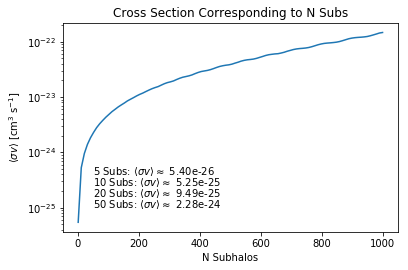

5.403317362745439e-26


In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('axes title')
n_subs = np.linspace(1, 1000, 100)
im = np.argmin(np.abs(100 - mass_arr))
xsec_nsubs = []
for n_s in n_subs: xsec_nsubs.append(0)
for t in range(trials):
    N_detect_thresh_ind = []
    for i in N_detect_thresh[im]:
        N_detect_thresh_ind.append(i[t])
    for ni, n_s in enumerate(n_subs):
        xsec_nsubs[ni] += (xsec_arr[np.argmin(np.abs(N_detect_thresh_ind - n_s))])/trials
ax.plot(n_subs, xsec_nsubs)
ax.text(50, 10**(-24.4), (r'5 Subs: $\langle \sigma v \rangle \approx$ {:.2e}').format(xsec_nsubs[np.argmin(np.abs(n_subs-5))]), fontsize=10)
ax.text(50, 10**(-24.6), (r'10 Subs: $\langle \sigma v \rangle \approx$ {:.2e}').format(xsec_nsubs[np.argmin(np.abs(n_subs-10))]), fontsize=10)
ax.text(50, 10**(-24.8), (r'20 Subs: $\langle \sigma v \rangle \approx$ {:.2e}').format(xsec_nsubs[np.argmin(np.abs(n_subs-20))]), fontsize=10)
ax.text(50, 10**(-25.0), (r'50 Subs: $\langle \sigma v \rangle \approx$ {:.2e}').format(xsec_nsubs[np.argmin(np.abs(n_subs-50))]), fontsize=10)
ax.set_yscale("log")
ax.set_xlabel("N Subhalos")
ax.set_ylabel("$\\langle \\sigma v \\rangle$ [cm$^3$ s$^{-1}$]")
ax.set_title("Cross Section Corresponding to N Subs")
plt.show()
print((xsec_nsubs[np.argmin(np.abs(n_subs-5))]))

In [14]:
np.save("subhalos2xsec", [n_subs, xsec_nsubs])

In [9]:
lim_cons = []
lim_thresh = []
lim_test = []
n_subs_arr = [1, 5, 10, 15]
colors = [ 'green', 'blue', 'm', 'goldenrod']
for t in tqdm_notebook(range(trials)):
    lim_cons_temp = []
    lim_thresh_temp = []
    lim_test_temp = []
    for n_subs in n_subs_arr:
        lim_temp = []
        for im in range(len(mass_arr)):
            for ix in range(len(xsec_arr)):
                if N_detect_cons[im][ix][t] >= n_subs: 
                    lim_temp.append(xsec_arr[ix])
                    break
                if ix == len(xsec_arr)-1: lim_temp.append(1e-10)
        lim_cons_temp.append(lim_temp)

    for n_subs in n_subs_arr:
        lim_temp = []
        for im in range(len(mass_arr)):
            for ix in range(len(xsec_arr)):
                if N_detect_thresh[im][ix][t] >= n_subs: 
                    lim_temp.append(xsec_arr[ix])
                    break
        lim_thresh_temp.append(lim_temp)

    for n_subs in n_subs_arr:
        lim_temp = []
        for im in range(len(mass_arr)):
            for ix in range(len(xsec_arr)):
                if N_detect_test[im][ix][t] >= n_subs: 
                    lim_temp.append(xsec_arr[ix])
                    break
        lim_test_temp.append(lim_temp)

    lim_cons.append(lim_cons_temp)
    lim_thresh.append(lim_thresh_temp)
    lim_test.append(lim_test_temp)

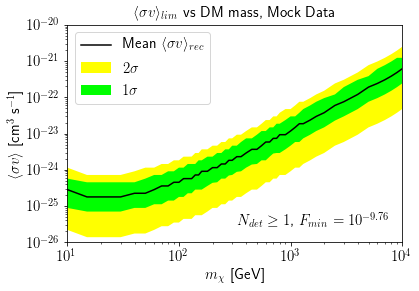

In [10]:
from matplotlib import rc
rc('text', usetex=True)
color = ['red', 'blue', 'cyan', 'purple']
fig, ax = plt.subplots()
for ni in range(len(n_subs_arr[:1])):
    lim_cons_ave = []
    lim_cons_1stdu = []
    lim_cons_1stdd = []
    lim_cons_2stdu = []
    lim_cons_2stdd = []
    for mi in range(len(mass_arr)):
        lim_cons_mass = []
        for t in range(trials):
            lim_cons_mass.append(lim_cons[t][ni][mi])
        lim_cons_ave.append(np.percentile(lim_cons_mass, 50))
        lim_cons_1stdu.append(np.percentile(lim_cons_mass, 84))
        lim_cons_1stdd.append(np.percentile(lim_cons_mass, 16))
        lim_cons_2stdu.append(np.percentile(lim_cons_mass, 97.5))
        lim_cons_2stdd.append(np.percentile(lim_cons_mass, 2.5))
    ax.plot((mass_arr), (lim_cons_ave), label="Mean $\\langle \\sigma v \\rangle_{rec}$", c="black")
    ax.fill_between((mass_arr), (lim_cons_2stdd), (lim_cons_2stdu), label="$2 \\sigma$", facecolor="yellow")
    ax.fill_between((mass_arr), (lim_cons_1stdd), (lim_cons_1stdu), label="$1 \\sigma$", facecolor="lime")

fig.text(0.87, 0.17, '$N_{det} \geq 1$, $F_{min} = 10^{'+("{0:.4}").format(np.log10(F_cons))+"}$",
         fontsize=15, color='black',
         ha='right', va='bottom')
    
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-26, 1e-20)
plt.xlim(1e1, 1e4)
plt.legend(fontsize=15, loc=2)
plt.xlabel("$m_{\chi}$ [GeV]", fontsize=15)
plt.ylabel("$\\langle \\sigma v \\rangle$ [cm$^3$ s$^{-1}$]", fontsize=15)
plt.title("$\\langle \\sigma v \\rangle_{lim}$ vs DM mass, Mock Data", fontsize=15)
plt.setp(ax.get_xticklabels(), fontsize=15);
plt.setp(ax.get_yticklabels(), fontsize=15);

In [11]:
lim_cons_arr = []
lim_thresh_arr = []
lim_test_arr = []
n_subs_arr = [1, 5, 10, 15]
colors = [ 'green', 'blue', 'm', 'goldenrod']
for n_subs in n_subs_arr:
    lim_temp = []
    for im in range(len(mass_arr)):
        for ix in range(len(xsec_arr)):
            if np.sum(np.array(N_detect_cons[im][ix]) >= n_subs) >= 0.95*trials: 
                lim_temp.append(xsec_arr[ix])
                break
            if ix == len(xsec_arr)-1: lim_temp.append(1e-10)
    lim_cons_arr.append(lim_temp)

for n_subs in n_subs_arr:
    lim_temp = []
    for im in range(len(mass_arr)):
        for ix in range(len(xsec_arr)):
            if np.sum(np.array(N_detect_thresh[im][ix]) >= n_subs) >= 0.95*trials: 
                lim_temp.append(xsec_arr[ix])
                break
    lim_thresh_arr.append(lim_temp)

for n_subs in n_subs_arr:
    lim_temp = []
    for im in range(len(mass_arr)):
        for ix in range(len(xsec_arr)):
            if N_detect_test[im][ix][t] >= n_subs: 
                lim_temp.append(xsec_arr[ix])
                break
    lim_test_arr.append(lim_temp)

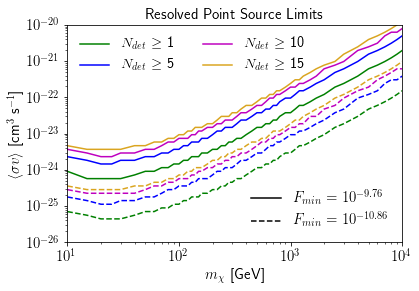

In [12]:
fig, ax = plt.subplots()
p = []
for il, l in enumerate(lim_cons_arr):
    p.append(ax.plot(mass_arr, l, label="$N_{det}$ $\geq$ " + str(n_subs_arr[il]), c=colors[il])[0])
    ax.plot(mass_arr, lim_thresh_arr[il], linestyle="--", c=p[-1].get_color())
#    ax.plot(mass_arr, lim_test[il], linestyle=":", c=p[-1].get_color())
    
#fig.text(0.45, 0.23, 'Preliminary',
#         fontsize=20, color='red',
#         ha='right', va='bottom', alpha=0.6)

solid, = ax.plot([-10.], [-10.], c="black", label="$F_{min} = 10^{"+("{0:.4}").format(np.log10(F_cons))+"}$")
dashed, = ax.plot([-10.], [-10.], c="black", label="$F_{min} = 10^{"+("{0:.4}").format(np.log10(F_thresh))+"}$", linestyle="--")
#dashed, = ax.plot([-10.], [-10.], c="black", label="$F_{min}$ = "+str(F_test), linestyle="--")

legend2 = plt.legend(handles=[solid, dashed], loc=4, frameon=False, fontsize=15)
plt.gca().add_artist(legend2)

plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-26, 1e-20)
plt.xlim(1e1, 1e4)
plt.legend(handles=p, ncol=2, frameon=False, fontsize=14.5)
plt.xlabel("$m_{\chi}$ [GeV]", fontsize=15)
plt.ylabel("$\\langle \\sigma v \\rangle$ [cm$^3$ s$^{-1}$]", fontsize=15)
plt.title("Resolved Point Source Limits", fontsize=15)
plt.setp(ax.get_xticklabels(), fontsize=15);
plt.setp(ax.get_yticklabels(), fontsize=15);